In [1]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=10,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)

print(client.dashboard_link)

/opt/tljh/user/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41667 instead
  http_address["port"], self.http_server.port
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:34477
distributed.scheduler - INFO -   dashboard at:           127.0.0.1:41667
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42983'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42331'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45823'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33391'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33969'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42029'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:46449'
distributed.nanny - INFO -         

http://127.0.0.1:41667/status


In [2]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import LassoCV

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [3]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/camcan_data",
    target_cols=["age"],
    index_col="Observations"
)

In [4]:
print(X.shape)
print(y.shape)
print(len(subjects))

(641, 3600)
(652,)
641


In [5]:
df_y = pd.read_csv("../data/raw/camcan_data/subjects.csv")
df_y.head()
df_y = df_y[["Observations", "age"]]
df_y = df_y.set_index("Observations", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs["age"].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [6]:
print(X.shape)
print(y.shape)

(640, 3600)
(640,)


In [7]:
len(groups)

36

(array([26., 58., 72., 68., 76., 64., 71., 74., 86., 45.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <BarContainer object of 10 artists>)

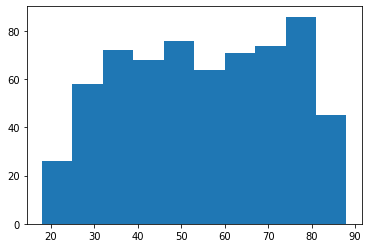

In [8]:
plt.hist(y)

In [9]:
np.median(y)

55.0

In [10]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10,
                   trim_nodes=0,
                   square_features=False):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
        
    if trim_nodes > 0:
        grp_mask = np.zeros_like(groups[0], dtype=bool)
        grp_mask[trim_nodes:-trim_nodes] = True
        X_mask = np.concatenate([grp_mask] * len(groups))

        groups_trim = []
        start_idx = 0
        
        for grp in groups:
            stop_idx = start_idx + len(grp) - 2 * trim_nodes
            groups_trim.append(np.arange(start_idx, stop_idx))
            start_idx += len(grp) - 2 * trim_nodes
            
        X_trim = X[:, X_mask]
    elif trim_nodes == 0:
        groups_trim = [grp for grp in groups]
        X_trim = np.copy(X)
    else:
        raise ValueError("trim_nodes must be non-negative.")
        
    if square_features:
        _n_samples, _n_features = X_trim.shape
        X_trim = np.hstack([X_trim, np.square(X_trim)])
        groups_trim = [np.concatenate([g, g + _n_features]) for g in groups_trim]
    
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.pipeline.make_base_afq_pipeline(
        imputer_kwargs={"strategy": "median"},
        power_transformer=power_transformer,
        scaler="standard",
        estimator=LassoCV,
        estimator_kwargs={
            "verbose": 0,
            "n_alphas": 50,
            "cv": 3,
            "n_jobs": 10,
            "max_iter": 500,
        },
        verbose=0,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )
    
    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ((target_transform_func is not None)
            or (target_transform_inverse_func is not None)):
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
        else:
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [13]:
results = {}

In [14]:
trim_nodes = 0

results[f"bagging_target_transform_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=False, n_estimators=20,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
    trim_nodes=trim_nodes, square_features=False,
)

results[f"bagging_pure_lasso_trim{trim_nodes}"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=False, n_estimators=20,
    trim_nodes=trim_nodes, square_features=False,
)

distributed.scheduler - INFO - Receive client connection: Client-worker-05008e5a-60f6-11eb-9f9e-dd97522b4486
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-13ef1810-60f6-11eb-9f92-df82e4492293
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-13ec8c8c-60f6-11eb-9f95-a734d0518417
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-13ee6218-60f6-11eb-9f95-a734d0518417
distributed.core - INFO - Starting established connection
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015607858984454825, tolerance: 0.007098896647946416
  positive)
distributed.scheduler - INFO - Receive client connection: Cl

CV index [  0], Elapsed time:  0:06:22.881380


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011903269556710505, tolerance: 0.0069822639272147284
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007269022054288143, tolerance: 0.007233653861436065
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007624960258405089, tolerance: 0.0071377793646794805
  positive)


CV index [  1], Elapsed time:  0:07:18.105866


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014328357183837959, tolerance: 0.0074535450688657705
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01580270603645939, tolerance: 0.006964467299292713
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007740065507162441, tolerance: 0.007383055143686088
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

CV index [  2], Elapsed time:  0:07:02.275307


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009759891122709252, tolerance: 0.00815581788249195
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021360477443487458, tolerance: 0.007592247760720318
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010560021224295113, tolerance: 0.007563733819944057
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

CV index [  3], Elapsed time:  0:07:17.666662


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014921689036646146, tolerance: 0.008212191485559907
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008018557512510682, tolerance: 0.007334339928655652
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011402212960265778, tolerance: 0.007738507367457684
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

CV index [  4], Elapsed time:  0:07:11.545419


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.071125057951576, tolerance: 17.7371935546875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.031649575967094, tolerance: 18.670646875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.855637136264704, tolerance: 16.7057373046875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

CV index [  0], Elapsed time:  0:06:49.944526


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.399549154917622, tolerance: 16.206087500000002
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.703760456597593, tolerance: 16.44303671875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.14538199353592, tolerance: 16.929000000000002
  positive)


CV index [  1], Elapsed time:  0:06:56.311332


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.659960146528647, tolerance: 17.7294373046875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.05770277344845, tolerance: 16.863605468750002
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.32407849183801, tolerance: 16.6893060546875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

CV index [  2], Elapsed time:  0:06:48.740259


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.719938788977743, tolerance: 18.774446875000002
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.85016551986564, tolerance: 17.736946875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.86033797431628, tolerance: 17.550962304687502
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

CV index [  3], Elapsed time:  0:07:06.678086


/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.06111568792403, tolerance: 17.26404921875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.783219860269583, tolerance: 17.1434
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.24403289662041, tolerance: 16.9685029296875
  positive)
/opt/tljh/user/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.18999

CV index [  4], Elapsed time:  0:05:18.229441


In [17]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    test_r2 = [cvr["test_r2"] for cvr in res[0].values()]
    train_r2 = [cvr["train_r2"] for cvr in res[0].values()]

    print(key, "mean MAE", np.mean(test_mae))
    print(key, "std MAE", np.std(test_mae))
    print(key, "mean R2", np.mean(test_r2))
    print(key, "std R2", np.std(test_r2))

bagging_target_transform_pure_lasso_trim0 mean MAE 6.330362853406251
bagging_target_transform_pure_lasso_trim0 std MAE 0.6054836981741665
bagging_target_transform_pure_lasso_trim0 mean R2 0.6159132118305084
bagging_target_transform_pure_lasso_trim0 std R2 0.17248964767938768
bagging_pure_lasso_trim0 mean MAE 5.812226433212865
bagging_pure_lasso_trim0 std MAE 0.24857972289826952
bagging_pure_lasso_trim0 mean R2 0.7710501335721306
bagging_pure_lasso_trim0 std R2 0.017581081832134637


In [18]:
with open("camcan_regression_pure_lasso.pkl", "wb") as fp:
    pickle.dump(results, fp)